In [1]:
import os
from pathlib import Path
import sys
import numpy as np
import scvelo as scv

In [4]:
notebook_dir = os.getcwd()
notebook_dir

'c:\\Users\\OmerCagatayTalikaci\\Desktop\\github\\STVelo\\notebooks\\pipeline_control'

In [5]:
Path(notebook_dir).parents[2]

WindowsPath('c:/Users/OmerCagatayTalikaci/Desktop/github')

In [4]:
os.chdir(Path(notebook_dir).parents[2])

In [5]:
stvelo_path = os.path.join(os.getcwd(),'STVelo','stvelo')

In [6]:
stvelo_path

'c:\\Users\\OmerCagatayTalikaci\\Desktop\\github\\STVelo\\stvelo'

In [7]:
import sys  
sys.path.insert(1,stvelo_path)
from pipelines.simulate_3ode import *
from pipelines.metrics import *
from pipelines.preprocessing import Preprocessing
from pipelines.compute_velocity import Velocities


# Input 

In [8]:


############## CONFIG PREPROCESSING #####################
config_preprocessing = {'preprocess_params': { 'min_counts': 200, 'min_cells': 5, 'n_neighbors': 23, 'n_pcs': 0, 'min_dist': 1}
                        ,'functions_to_apply': {'filter_cells': True,  'filter_genes': True,   'normalize_total': True,  'log1p': True,
'pca': True,   'neighbors': True,   'umap': True,   'leiden': True,   'moments': True}}

############## CONFIG VELOCITY #####################
# config_velocity = { 'velocity_types': ['dynamical','deterministic','stochastic','velovi']}
config_velocity = { 'velocity_types': ['dynamical','deterministic']}

############# CONFIG PLOTTING ######################



In [ ]:
n_cells=800
n_genes=300
t_max=20 #### maybe could be fix?
mu = np.array([3, 1.8, 0.8, 0.5])

R = np.array([[.16, .128, .08, .032],
              [.128, .16 , .08, .032],
              [.08, .08, .16 , .08],
              [.032 ,.032 , .08 , .16]])

C = np.array([0.4, 0.4, 0.4, 0.4])[:, None]

# Simulation

In [9]:
cov = C * R
cov=np.log(cov)
alpha, beta , nu, gamma = np.exp(np.random.multivariate_normal(mu, cov, size = n_genes).T)
s = switch_times(20,300)

In [10]:
adata_dict = simulation_3ode(n_obs=n_cells,alpha=alpha, beta= beta, nu=nu, gamma=gamma, t_max=t_max, switches=s/20,n_vars=n_genes)

# Spatial artifacts would go here

# Preprocessing

In [11]:
for key, adata in adata_dict.items():
    print(f'{key} is being preprocessed.')
    preprocessor = Preprocessing(adata,config_preprocessing)
    adata = preprocessor.preprocess_data()

adata_s_u is being preprocessed.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
adata_n_c is being preprocessed.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# Velocities

In [12]:
velocity_computer = Velocities(adata_dict,config_velocity)
adata_dict_velocity = velocity_computer.compute_velocities()

Using device: cuda
recovering dynamics (using 8/24 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:16) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/24 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/24 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
recovering dynamics (using 8/24 cores)
    finished (0:00:04) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity 

# Plotting 

In [13]:
from pipelines.plot import Plotter

In [20]:
saving_plots_path = os.path.join(os.getcwd(),'outputs','plots')
saving_plots_path

'c:\\Users\\OmerCagatayTalikaci\\Desktop\\github\\outputs\\plots'

In [14]:
import matplotlib.pyplot as plt

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
An error occurred while generating velocity_embedding_stream for clusters: color key is invalid! pass valid observation annotation or a gene name
An error occurred while generating velocity_embedding_grid for clusters: color key is invalid! pass valid observation annotation or a gene name
An error occurred while generating velocity_embedding for clusters: color key is invalid! pass valid observation annotation or a gene name
ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


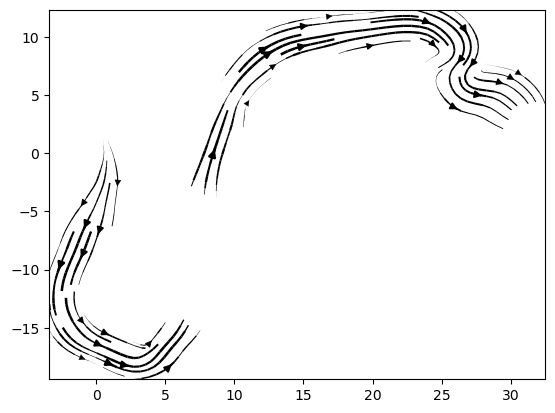

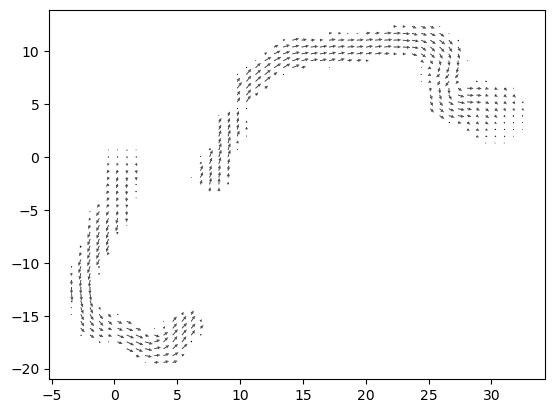

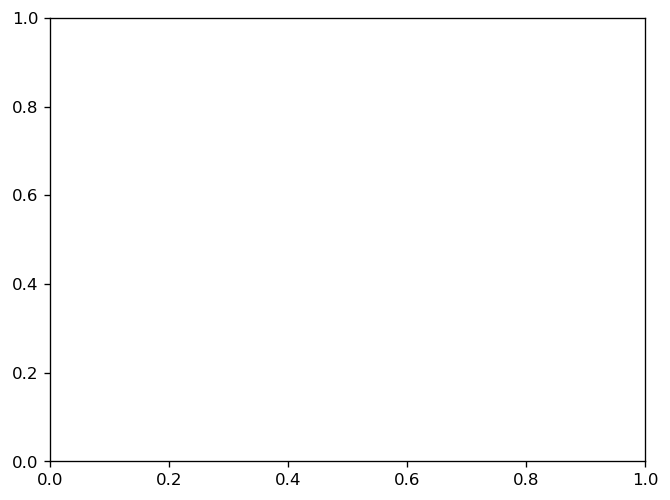

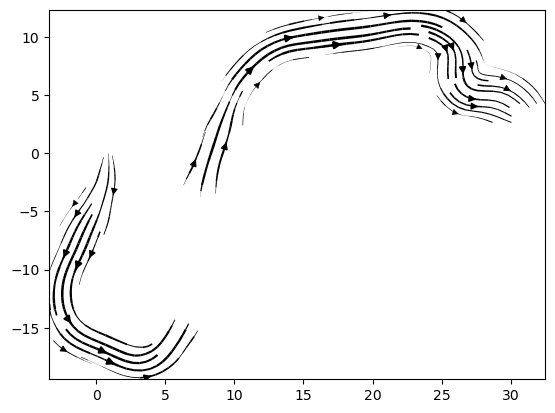

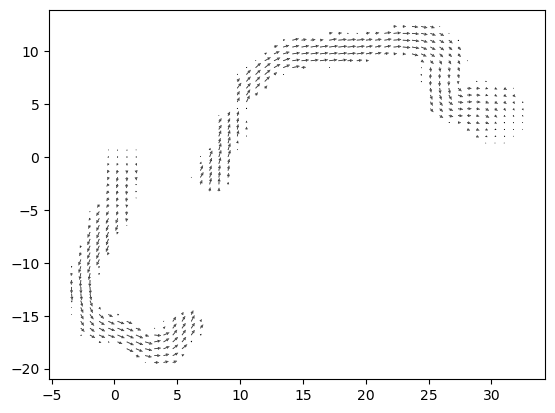

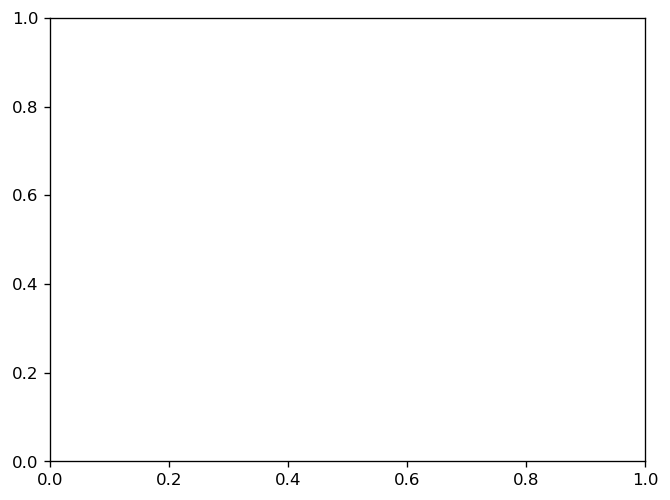

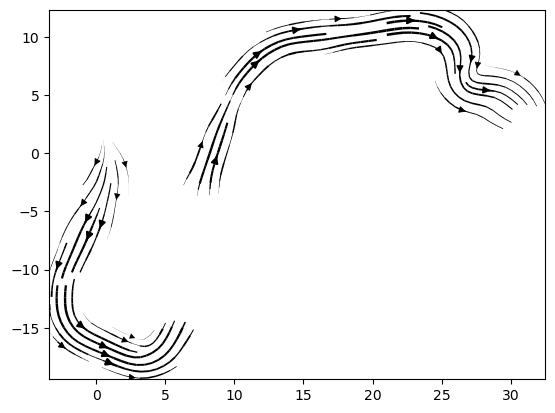

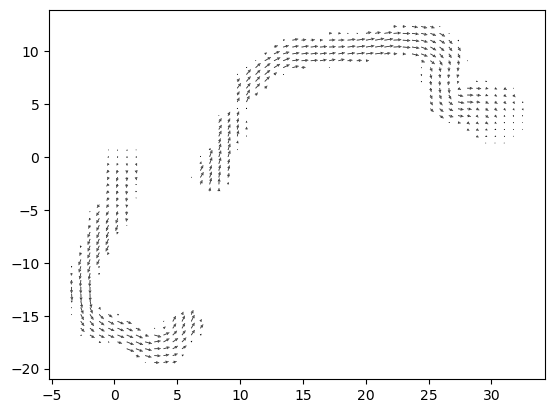

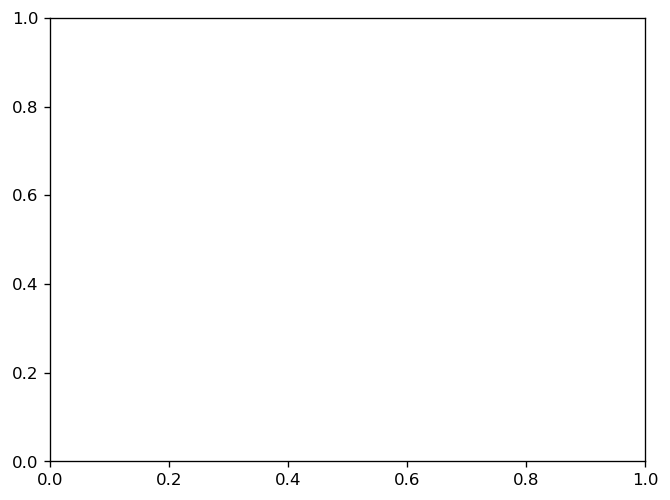

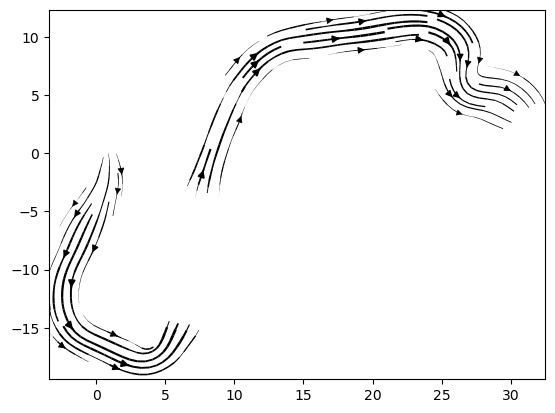

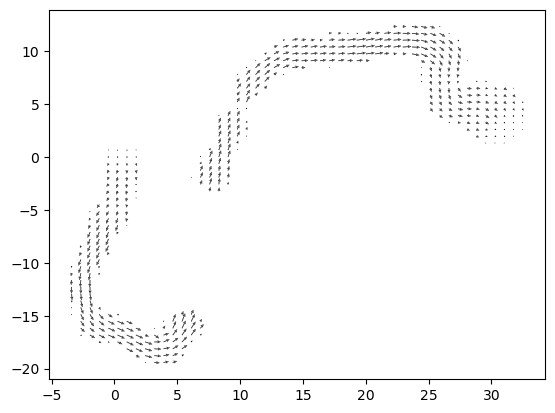

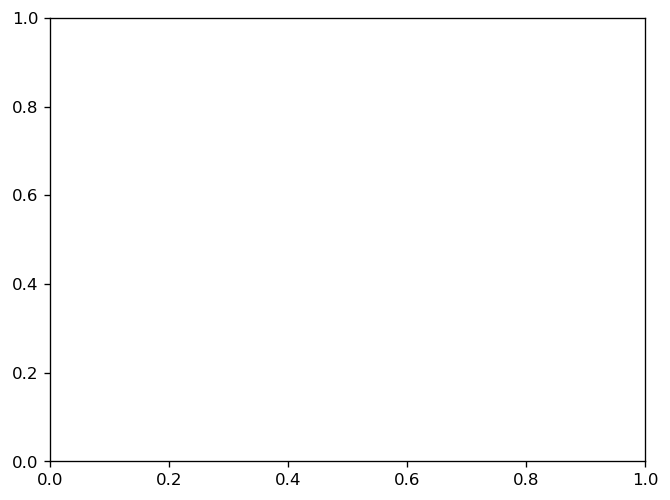

In [15]:
config = {
    'colorsets': ['leiden', 'clusters'],
    'velocity_embedding_stream': True,
    'velocity_embedding_grid': True,
    'velocity_embedding': True,
    'rank_velocity_genes': True,
    'velocity_confidence': True,
    'velocity_length': True
}

saving_plots_path = os.path.join(os.getcwd(),'outputs','plots')

# Create an instance of the class
plotter = Plotter(adata_dict=adata_dict_velocity, config=config, saving_path=saving_plots_path,saving_format='png')

# Generate the plots
plotter.generate_plots(save=True)

# This will be implemented into a function (basic plotting)

In [16]:
ad = adata_dict_velocity['adata_n_c_deterministic']

In [19]:
saving_plots_path

'c:\\Users\\OmerCagatayTalikaci\\Desktop\\github\\outputs\\plots'

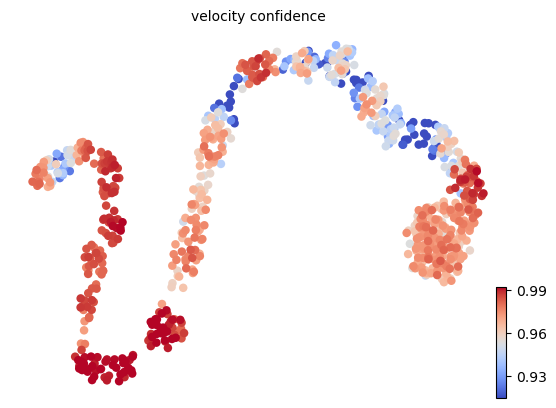

In [20]:
scv.pl.scatter(ad, c='velocity_confidence', cmap='coolwarm', perc=[5, 95],show=False)
plt.savefig(os.path.join(saving_plots_path,'umap_confidence.png'))


In [ ]:
import os 
if not os.path.exists(saving_plots_path):
    os.mkdir(saving_plots_path)
for d in adata_dict_velocity.keys():
    adata=adata_dict_velocity[d]
    saving_adata_path=os.path.join(saving_plots_path,d)
    if not os.path.exists(os.path.join(saving_plots_path,d)):
        os.mkdir(os.path.join(saving_plots_path,d))
    sets=['leiden']
    for colorset in sets:
        try:
            scv.pl.velocity_embedding_stream(adata, basis='umap',color=colorset,show=False)
            plt.savefig(os.path.join(saving_adata_path,'UMAP_{}_velocity_stream.svg'.format(colorset)))
            scv.pl.velocity_embedding_grid(adata, basis='umap',color=colorset,show=False)
            plt.savefig(os.path.join(saving_adata_path,'UMAP_{}_velocity_grid.svg'.format(colorset)))
            scv.pl.velocity_embedding(adata, arrow_length=3,color=colorset, arrow_size=2, dpi=120,show=False)
            plt.savefig(os.path.join(saving_adata_path,'UMAP_{}_velocity_embedding.svg'.format(colorset)))
        except:
            pass
    ####
    scv.tl.rank_velocity_genes(adata, groupby='leiden', min_corr=.3)
    df = pd.DataFrame(adata.uns['rank_velocity_genes']['names'])
    for col in df.columns:
        scv.pl.scatter(adata, df[col][:5], ylabel=col,color='leiden',show=False)
        plt.savefig(os.path.join(saving_adata_path,'scatterplot_velo_{}.svg'.format(col)))
        scv.pl.velocity(adata, df[col][:5], ncols=2, add_outline=True,show=False)
        plt.savefig(os.path.join(saving_adata_path,'velocity_plots_{}.svg'.format(col)))
    scv.tl.velocity_confidence(adata)
    scv.pl.scatter(adata, c='velocity_confidence', cmap='coolwarm', perc=[5, 95],show=False)
    plt.savefig(os.path.join(saving_adata_path,'umap_confidence.svg'))
    scv.pl.scatter(adata, c='velocity_length', cmap='coolwarm', perc=[5, 95],show=False)
    plt.savefig(os.path.join(saving_adata_path,'umap_velocity_length.svg'))

# Save results (if needed)

In [65]:
for d in adata_dict_velocity.keys():
    print(d)
    adata_dict_velocity[d].write(os.path.join(saving_adata_path,d+'.h5ad'))

# Performance metrics (this should also be a function, tbd)

In [ ]:
# confidence 
for d in adata_dict.keys():
    print(d)
    adata_dict[d]=compute_confidence(adata_dict[d])
    
#velocity correlations (by gene or by cell)
velo_corr_bygene=velocity_mean_correlation(adata_dict,mode='by_gene')
velo_corr_bycell=velocity_mean_correlation(adata_dict,mode='by_cell')

# velocity corr against a reference 
velocity_correlation_by_gene=velocity_corr_against_reference(adata_dict,reference='adata_s_u_deterministic', mode= 'by_gene')
velocity_correlation_by_cell=velocity_corr_against_reference(adata_dict,reference='adata_s_u_deterministic', mode= 'by_cell')

#velo mse 
velo_mse_bygene=velocity_mean_mse(adata_dict,mode='by_gene')
velo_mse_bycell=velocity_mean_mse(adata_dict,mode='by_cell')

# velo mse against a reference 
velocity_mse_by_gene=velocity_mse_against_reference(adata_dict,reference='adata_s_u_deterministic', mode= 'by_gene')
velocity_mse_by_cell=velocity_mse_against_reference(adata_dict,reference='adata_s_u_deterministic', mode= 'by_cell')

In [ ]:
# velocity sign
sign_accuracies=get_sign_accuracy(adata_dict)


# Plotting metrics

In [ ]:
# confidence
import seaborn as sns
confidences=get_confidences(adata_dict)
sns.violinplot(data=confidences,x='Velocity confidence',y='velo_type')

In [ ]:
# velocity correlations (by gene or by cell)
sns.clustermap(velo_corr_bygene.astype(float),figsize=(5,5))
sns.clustermap(velo_corr_bycell.astype(float),figsize=(5,5))

In [ ]:
# velocity corr against a reference 
import matplotlib.pyplot as plt
sns.clustermap(velocity_correlation_by_gene.fillna(0),figsize=(7,4),cmap='Blues')
plt.figure(figsize=(5,5))
sns.boxplot(data=velocity_correlation_by_gene.stack().reset_index(),y='level_0',x=0,palette='Blues')
plt.xlabel('Correlation against reference')
plt.ylabel('Modality')

# same, but by cell
import matplotlib.pyplot as plt
sns.clustermap(velocity_correlation_by_cell.fillna(0),figsize=(7,4),cmap='Blues')
plt.figure(figsize=(5,5))
sns.boxplot(data=velocity_correlation_by_cell.stack().reset_index(),y='level_0',x=0,palette='Blues')
plt.xlabel('Correlation against reference')


In [ ]:
# velo mse
sns.clustermap(velo_mse_bygene.astype(float),figsize=(5,5))
sns.clustermap(velo_mse_bycell.astype(float),figsize=(5,5))

In [ ]:
# velo mse against reference 
import matplotlib.pyplot as plt
sns.clustermap(velocity_mse_by_gene.fillna(0),figsize=(7,4),cmap='Purples')
plt.figure(figsize=(5,5))
sns.boxplot(data=velocity_mse_by_gene.stack().reset_index(),y='level_0',x=0,palette='Purples')
plt.xlabel('MSE against reference')
plt.ylabel('Modality')


In [ ]:
# plotting velocity signs
sns.violinplot(data=sign_accuracies,y='Model',x='Accuracy',palette='viridis')